In [2]:
import h5py
import numpy as np
import os
import glob 
from sklearn.decomposition import PCA
from einops import rearrange
import matplotlib.pyplot as plt
import sparrow
from tqdm import tqdm
import pandas as pd

In [3]:
aa_to_int = {
    "0": 0,
    "A": 1,
    "C": 2,
    "D": 3,
    "E": 4,
    "F": 5,
    "G": 6,
    "H": 7,
    "I": 8,
    "K": 9,
    "L": 10,
    "M": 11,
    "N": 12,
    "P": 13,
    "Q": 14,
    "R": 15,
    "S": 16,
    "T": 17,
    "V": 18,
    "W": 19,
    "Y": 20,
}

int_to_aa_map = {v: k for k, v in aa_to_int.items()}

def decode(sequence):
    
    """
    Decode a sequence of integers into a string of amino acids.
    """
    return "".join([int_to_aa_map[i] for i in sequence if i != 0])

In [4]:
latent_paths = glob.glob('/work/bnovak/projects/sequence2ensemble/lammps_data/mPIPIgg_70k_seqs/IDRs*/preprocessed_data/*vae_encoded.h5')

print(f'There are {len(latent_paths)} latent files')

There are 61811 latent files


In [5]:
import multiprocessing as mp
from functools import partial

def process_latent_file(latent_path):
    """Process a single latent file and return the sequence and latent vector."""
    with h5py.File(latent_path, 'r') as f:
        sequence = decode(f['seq'][:])
        latent = f['average_latent'][:]
    return sequence, latent

# Determine number of processes to use (leave some cores free)
num_processes = max(1, mp.cpu_count() - 2)
print(f"Using {num_processes} processes")

# Create a pool of workers
with mp.Pool(processes=num_processes) as pool:
    # Map the worker function to all paths and collect results
    results = list(tqdm(
        pool.imap(process_latent_file, latent_paths),
        total=len(latent_paths),
        desc="Processing files"
    ))
    
# Separate the results into sequences and latents
sequences, latents = zip(*results)
sequences = list(sequences)
latents = list(latents)

# Stack latents for further processing
latents = np.stack(latents, axis=0)
print(f"Processed {len(sequences)} sequences")

Using 14 processes


Processing files: 100%|██████████| 61811/61811 [01:40<00:00, 614.97it/s] 


Processed 61811 sequences


In [6]:
sequences_pd = pd.DataFrame(sequences, columns=['sequence'])

sequences_pd['length'] = sequences_pd['sequence'].apply(len)
# sequences_pd['rg'] = sequences_pd['sequence'].apply(lambda x: sparrow.Protein(x).predictor.radius_of_gyration())

In [7]:
pca = PCA(n_components=10)

latent_vectors = rearrange(latents, 'b n d -> b (n d)')

latent_pca = pca.fit_transform(latent_vectors)

pca.explained_variance_ratio_.sum()

0.9795799

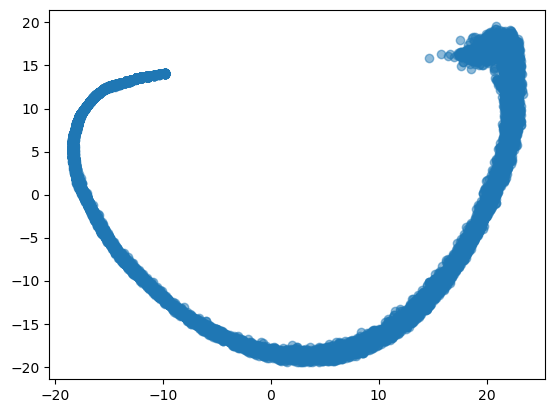

In [8]:
plt.scatter(latent_pca[:, 0], latent_pca[:, 1], alpha=0.5)

In [28]:
latents_pca_subsampled = latent_pca[(sequences_pd['length'] > 300) & (sequences_pd['length'] < 350)]

In [40]:
from sklearn.metrics.pairwise import pairwise_distances

dist_matrix = pairwise_distances(latents_pca_length_50, metric='euclidean')

In [29]:
from sklearn.cluster import KMeans
import numpy as np

# latent_pca: shape (70000, latent_dim)
n_clusters = 50  # You can try 200 or 300 if you want finer groups

kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init='auto')
kmeans.fit(latents_pca_subsampled)

# Get cluster centroids
centroids = kmeans.cluster_centers_  # shape (n_clusters, latent_dim)

In [34]:
from collections import defaultdict

cluster_to_sequences = defaultdict(list)

for seq, label in zip(sequences_pd[(sequences_pd['length'] > 300) & (sequences_pd['length'] < 350)]['sequence'].to_list(), kmeans.labels_):
    cluster_to_sequences[label].append(seq)

/home/borna/miniconda3/envs/labconda/lib/python3.8/site-packages/sparrow/predictors/scaled_rg/scaled_radius_of_gyration_predictor.py:103: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental 

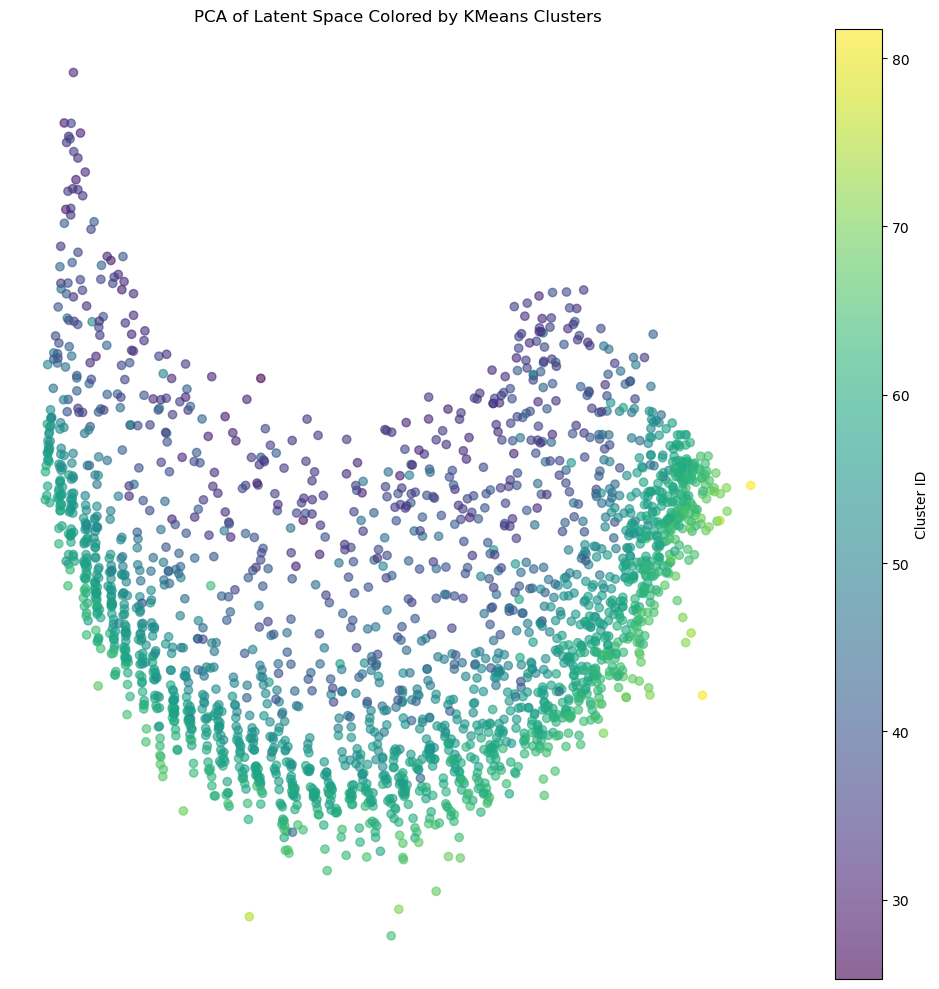

In [38]:
pca_2d = PCA(n_components=2)
latent_2d = pca_2d.fit_transform(latents_pca_subsampled)

labels = [sparrow.Protein(seq).predictor.radius_of_gyration() for seq in sequences_pd[(sequences_pd['length'] > 300) & (sequences_pd['length'] < 350)]['sequence'].to_list()]
# labels = [len(seq) for seq in sequences_pd[(sequences_pd['length'] > 300) & (sequences_pd['length'] < 350)]['sequence'].to_list()]

# Plot with cluster coloring
plt.figure(figsize=(10, 10))
plt.scatter(
    latent_2d[:, 0],
    latent_2d[:, 1],
    c=labels,
    alpha=0.6
)
plt.title("PCA of Latent Space Colored by KMeans Clusters")
plt.axis('off')
plt.colorbar(label="Cluster ID")
plt.tight_layout()
plt.show()

In [44]:
from sklearn.metrics import pairwise_distances

centroid_dist = pairwise_distances(centroids, metric='euclidean')

In [45]:
from scipy.cluster.hierarchy import linkage, leaves_list

linkage_matrix = linkage(centroids, method='ward')
leaf_order = leaves_list(linkage_matrix)

# Reorder distance matrix and optionally cluster labels
centroid_dist_reordered = centroid_dist[leaf_order][:, leaf_order]

In [48]:
closest_indices = np.argsort(dist_matrix, axis=1)[:, 1:10]

In [49]:
for i in closest_indices[10]:
    print(sparrow.Protein(sequences[i]).predictor.end_to_end_distance().round(2), sequences[i])

88.02 VILLLEQGKAPWMVKRELTKGLCSGWEPICETEELTPKQDFYEEHQSQKIIETLTSYNLEYSSLREEWKCEGYFERQPGNQKACFKEEIITHEEPLFDEREQEYKSWGSFHQNPLLCTQKIIPKEEKVHKHDTQKRSFKKNLMAIKPKSVCAEKKLLKCNDC
89.49 MPAPGALILLAAVSASGCLASPAHPDGFALGRAPLAPPYAVVLISCSGLLAFIFLLLTCLCCKRGDVGFKEFENPEGEDCSGEYTPPAEETSSSQSLPDVYILPLAEVSLPMPAPQPSHSDMTTPLGLSRQHLS
58.41 GQGTRAVQEKETKIKDFPRFQETTKLSIRDPEQGLEGSLEQPASPRKVLEELSHQSPENLVSLA
87.15 MALYDEDLLKNPFYLALQKCRPDLCSKVAQIHGIVLVPCKGSLSSSIQSTCQFESYILIPVEEHFQTLNGKDVFIQGNRIKLGAGFACLLSVPILFEETFYNEKEESFSILCIAHPLEKRESSEEPLAPSDPFSLKTIEDVREFLGRH
59.69 EQEALMEQQDPKSPSHKSKRQQQELIAELRRRQVKDNRHVYEGKDGAIEDIITVLKTVPFTARTAKRGSRFFCEPVLTEEYHY
129.48 FLRRADSLVSATEMAMFRRVNEPHELPPTDRYGRPPYRGGLDRQSSVTVTESQFLKRNGRYEDEHPSYQEVKAQAGSFPVKNLTQRRPLSARSYSTESYGASQTRPVSARPTMAALLEKIPSDYNLGNYGDKPSDNSDLKTRPTPVKGEESCGKMPADWRQQLLRHIEARRLDRNAAYKHNTVNLGMLPYGGISAMHAGRSMTLNLQTKSKFDHQELPLQKTPSQQSNILDNGQEDVSPSGQWNPYPLGRRDVPPDTITKKAGSHIQTLMGSQSLQHRSREQQPYEGNINKVTIQQFQSPLPIQIPSSQATRGPQPGRCLIQTKGQRSMDGYPEQFCVRIEK
127.72 MPEWPPCLSVAPALVIT

/home/borna/miniconda3/envs/labconda/lib/python3.8/site-packages/sparrow/predictors/scaled_re/scaled_end_to_end_distance_predictor.py:103: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental